In [1]:
import numpy as np
from numpy import pi
from ssid import okid, ExtractModes
from control.matlab import ss
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from scipy import signal
from scipy.signal import dimpulse as _dimpulse
def dimpulse(*args, **kwds):
    t,a = _dimpulse(*args, **kwds)
    return [ai.squeeze() for ai in a],t 
from matplotlib import pyplot as plt
from collections import defaultdict


# Real Time History Data

In [11]:
# See the real response data to test

import pickle
from datetime import datetime
from CE58658.utilities import husid

with open('../../CalTrans.Hayward/Studies/rawRHs.dat', 'rb') as f:
    rawRHs = pickle.load(f)

def plotSensorRH(rawRHs, event_date, channel_numbers, dt, windowed=False):   
    event = rawRHs[event_date]

    accel_unit_label = r"$\ddot{u}$ [g]"
    accel_scale = 1/980.665
    displ_unit_label = r"$u$ [in]"
    displ_scale = 1/2.54

    fig, ax = plt.subplots(len(channel_numbers), 2, figsize=(12,1.75*len(channel_numbers)), constrained_layout=True)
    if dt is not None:
        x_units = "s"
    else:
        dt = 1.0
        x_units = "timestep"
    sensorRH0 = event['24']['accel']*accel_scale
    times = dt*np.arange(len(sensorRH0))
    if windowed:
        window = husid(sensorRH0, False, dt, lb=0.025, ub=0.975)
        times = times[window[0]:window[1]]
    else:
        window = [0,len(sensorRH0)]
        fig, ax = plt.subplots(1,2,figsize=(15,3))

    accels = defaultdict(dict)
    for i,nm in enumerate(channel_numbers):
        accel_series = event[nm]['accel'][window[0]:window[1]]*accel_scale
        accels[nm] = event[nm]['accel']*accel_scale
        displ_series = event[nm]['displ'][window[0]:window[1]]*displ_scale
        direction = event[nm]['direction']
        channel_name = event[nm]['channel_name']
        ax[i,0].plot(times, accel_series, linewidth=0.75)
        ax[i,0].set_ylabel(f"{accel_unit_label}")
        ax[i,0].set_title(f"Channel {nm} ({channel_name}) ({direction})")
        ax[i,1].plot(times, displ_series, linewidth=0.75)
        ax[i,1].set_ylabel(f"{displ_unit_label}")
        ax[i,1].set_title(f"Channel {nm} ({channel_name}) ({direction})")
    ax[-1,0].set_xlabel(f"time [{x_units}]")
    ax[-1,1].set_xlabel(f"time [{x_units}]")
    fig.suptitle(f"Response History of {datetime.strptime(event_date, '%Y-%m-%dT%H:%M:%S')}")
    fig.align_labels()
    plt.show()
    return accels

def getSensorRH(rawRHs, event_date, channel_numbers):   
    event = rawRHs[event_date]
    accel_scale = 1/980.665
    accels = defaultdict(dict)
    for nm in channel_numbers:
        accels[nm] = event[nm]['accel']*accel_scale
    return accels

CHANNELS = {
# channel node dof rotationangle locationname
    "1": (1031, 3, 37.66*pi/180, "abutment_1"),
    "2": (1031, 2, 37.66*pi/180, "abutment_1"),
    "3": (1031, 1, 37.66*pi/180, "abutment_1"),
    "6": (307, 1, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "7": (307, 2, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "11": (1030, 3, 37.66*pi/180, "deck_level_near_abut_1"),
    "12": (1030, 1, 37.66*pi/180, "deck_level_near_abut_1"),
    "13": (1030, 2, 37.66*pi/180, "deck_level_near_abut_1"),
    "14": (304, 1, 31.02*pi/180, "bent_3_deck_level"),
    "15": (304, 2, 31.02*pi/180, "bent_3_deck_level"),
    # "16": (30003, 3, ((31.02+26.26)/2)*pi/180, "midspan_between_bents_3_4_deck"),
    "17": (401, 1, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "18": (401, 2, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "19": (402, 1, 26.26*pi/180, "bent_4_north_column_top"),
    "20": (402, 2, 26.26*pi/180, "bent_4_north_column_top"),
    "21": (405, 3, 26.26*pi/180, "bent_4_deck_level"),
    "22": (405, 1, 26.26*pi/180, "bent_4_deck_level"),
    "23": (405, 2, 26.26*pi/180, "bent_4_deck_level"),
    "24": (407, 1, 26.26*pi/180, "bent_4_south_column_grnd_level"),
    "25": (407, 2, 26.26*pi/180, "bent_4_south_column_grnd_level")
}

NODE_INFO = {
# key is node number, value is ((ch1,ch2,ch3), location name, rotation angle).
    '1031':  ((3,2,1),        'abutment_1',                      -37.66*pi/180),
    '1030':  ((12,13,11),     'deck_level_near_abut_1',          -37.66*pi/180),
    '304':   ((14,15,None),   'bent_3_deck_level',               -31.02*pi/180),
    '307':   ((6,7,None),     'bent_3_south_column_grnd_level',  -31.02*pi/180),
    '30003': ((None,None,16), 'midspan_between_bents_3_4_deck',  -((31.02+26.26)/2)*pi/180), 
    '401':   ((17,18,None),   'bent_4_north_column_grnd_level',  -26.26*pi/180),
    '402':   ((19,20,None),   'bent_4_north_column_top',         -26.26*pi/180),
    '405':   ((22,23,None),   'bent_4_deck_level',               -26.26*pi/180),
    '407':   ((24,25,None),   'bent_4_south_column_grnd_level',  -26.26*pi/180)
}

channel_numbers = CHANNELS.keys()
channel_numbers = ['12', '13', '14', '15', '18', '19', '20', '22', '23']
output_channel_numbers = ['12', '13', '14', '15', '19', '20', '22', '23']

# event_dates = ['2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-07-23T15:59:00', '2021-08-03T19:52:00']
event_dates = ['2022-02-16T01:46:00', '2022-02-16T05:05:00', '2022-02-16T14:20:00', '2022-02-16T15:50:00', '2021-10-11T16:22:00', '2022-02-16T00:08:00', '2022-02-16T06:09:00', '2022-02-16T08:35:00', '2022-02-16T09:36:00', '2022-02-16T12:58:00', '2022-02-16T14:05:00', '2022-02-16T15:39:00', '2022-02-16T15:56:00', '2022-02-16T17:57:00', '2022-03-01T15:29:00', '2022-04-05T23:10:00', '2022-06-07T14:22:00', '2022-12-28T19:52:00', '2023-01-30T17:55:00', '2021-10-20T19:01:00', '2022-02-16T16:03:00', '2022-03-15T18:12:00', '2022-04-14T14:26:00', '2022-06-14T18:35:00', '2023-02-01T18:22:00', '2021-05-18T20:38:00', '2022-03-17T01:13:00', '2022-05-25T19:45:00', '2022-06-20T16:12:00', '2021-10-29T22:43:00', '2022-03-18T18:46:00', '2022-07-07T20:31:00', '2021-10-07T18:51:00', '2021-11-03T16:28:00', '2022-07-25T19:09:00', '2021-11-05T19:07:00', '2022-08-15T01:55:00', '2021-04-26T17:09:00', '2022-09-06T19:28:00', '2021-11-17T02:00:00', '2022-09-12T10:26:00', '2021-11-17T19:43:00', '2022-09-27T21:49:00', '2022-01-17T15:38:00', '2022-01-24T19:12:00', '2022-11-04T18:31:00', '2022-02-07T00:01:00', '2022-02-12T03:13:00', '2022-02-15T20:01:00', '2022-12-13T21:40:00', '2021-05-12T16:31:00', '2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-10-02T19:22:00', '2021-07-23T15:59:00', '2021-10-05T19:19:00', '2021-08-03T19:52:00', '2021-08-03T23:45:00', '2021-08-19T15:30:00', '2021-11-05T22:20:00', '2021-04-30T16:40:00']
accelRHs = defaultdict(dict)
for event_date in event_dates:
    accelRHs[event_date] = getSensorRH(rawRHs, event_date, channel_numbers)

# Dataset for each channel combination for each model order for each event

In [23]:
dt = 0.01
q = 1 # 1 input channel
ylist = []
for i in range(256):
    channel_switches = [True, True, True, True, True, True, True, True]
    output_channels = np.array(output_channel_numbers)[channel_switches]
    p = len(output_channels)
    ylist_rs = []
    for r in [10, 20, 50]:
        ylist_events = []
        for event_date in event_dates:    
            yCGSTHlist = []
            cgs_input = accelRHs[event_date]['18']
            window = husid(cgs_input, False, dt, lb=0.03, ub=0.9)
            for ch in output_channels:
                yCGSTHlist.append(accelRHs[event_date][ch][window[0]:window[1]])
            yCGSTH = (np.array([yCGSTHlist]).transpose(1,0,2))
            mco = min(50,int(np.floor((yCGSTH.shape[2]-1)/2))) # m_o = m_c = (nt-1)/2
            # print(mco)
            Ar,Br,Cr,Dr,HSVs = okid.era(yCGSTH,mco,mco,p,q,r)
            modes = ExtractModes.modes(dt, Ar, Cr)
            periods = [1/f for f in sorted([modes[str(i)]['freq'] for i in range(3)])]
            ylist_events.append(periods)
            # print(periods)
        ylist_rs.append(ylist_events)
    ylist.append(ylist_rs)

print(ylist)

[0.08604928940398726, 0.06207685305143645, 0.06207685305143645]
[0.08110761382260898, 0.06152591085457111, 0.06152591085457111]
[0.7158919976852228, 0.7158919976852228, 0.1960826496002577]
[0.05815901120466932, 0.05121485089065083, 0.05121485089065083]
[0.6834501648931932, 0.1636695163869066, 0.1636695163869066]
[0.0833269920148711, 0.0503299428709713, 0.0503299428709713]
[0.6247011542522705, 0.6247011542522705, 0.20799081795212584]
[0.06487945770912762, 0.05886001562460132, 0.05886001562460132]
[0.06507130748229968, 0.05317936521611997, 0.05317936521611997]
[0.07591148529915015, 0.06973975888891523, 0.06973975888891523]
[0.6627156760755397, 0.6627156760755397, 0.06385428778058438]
[0.06222007121306964, 0.0532027636716663, 0.0532027636716663]
[0.06182664146591514, 0.053518125723232, 0.053518125723232]
[0.09642375778753894, 0.07635287072902823, 0.07635287072902823]
[0.07494238060266545, 0.07022144343872141, 0.07022144343872141]
[0.0910371500549127, 0.07244061441062377, 0.072440614410623

KeyboardInterrupt: 

# Modal Identification from Time History Experiments

In [50]:
opsperiods = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")[:3]
cgsPds = defaultdict(dict)

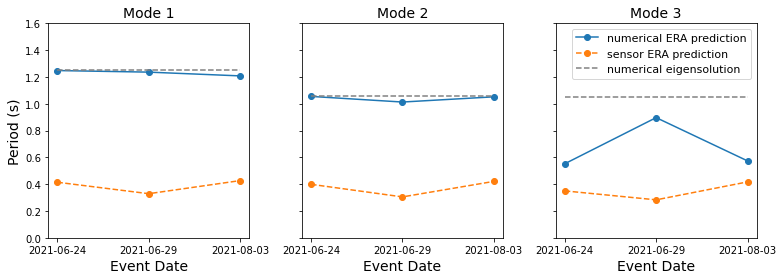

In [51]:
for m in range(3):
    # opsPds[str(m+1)] = [Periods['exp1']['ops'][m], Periods['exp2']['ops'][m], Periods['exp3']['ops'][m], Periods['exp4']['ops'][m]]
    opsPds[str(m+1)] = [Periods['exp1']['ops'][m], Periods['exp2']['ops'][m], Periods['exp4']['ops'][m]]
    # cgsPds[str(m+1)] = [Periods['exp1']['cgs'][m], Periods['exp2']['cgs'][m], Periods['exp3']['cgs'][m], Periods['exp4']['cgs'][m]]
    cgsPds[str(m+1)] = [Periods['exp1']['cgs'][m], Periods['exp2']['cgs'][m], Periods['exp4']['cgs'][m]]

fig, ax = plt.subplots(1,3, figsize=(11,4), tight_layout=True, sharey=True)
ax[0].set_ylim((0,1.6))
ax[0].set_ylabel("Period (s)", fontsize=14)
for m in range(3):
    ax[m].plot(event_dates, opsPds[str(m+1)], '-o', label='numerical ERA prediction')
    ax[m].plot(event_dates, cgsPds[str(m+1)], '--o', label='sensor ERA prediction')
    ax[m].plot(event_dates, Periods['eigen']['ops'][m]*np.ones(3), '--', color='gray', label='numerical eigensolution')
    ax[m].set_xlabel("Event Date", fontsize=14)
    ax[m].set_title(f"Mode {m+1}", fontsize=14)
ax[2].legend(fontsize=11);